In [2]:
# Importamos librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Cargamos el archivo CSV
df = pd.read_csv('iot_sensor_corrupted_dataset.csv')

# Vista preliminar
df.head()

,timestamp,device_id,temperature_C,humidity_%,status
0,2030-05-15 00:00:00,ESP32_A2,26.490142,47.391160456649544,OK
1,2023-01-01 00:30:00,ESP32_A2,24.585207,69.17861947054776,OK
2,2023-01-01 01:00:00,ESP32_B1,26.943066,-10.0,OK
3,2023-01-01 01:30:00,ESP32_B1,29.569090,70.32465260551147,OK
4,2023-01-01 02:00:00,ESP32_A1,NaN,44.80630034045987,OK


In [3]:
# - Dimensiones del dataset
# - Tipos de datos
# - Valores faltantes

print("Filas y Columnas:", df.shape)

# Tipos de datos
print(df.dtypes)

# Valores nulos
print(df.isna().sum())
df.info()

Dimensiones (filas, columnas): (260, 5)

Tipos de datos:
timestamp         object
device_id         object
temperature_C    float64
humidity_%        object
status            object
dtype: object

Valores nulos por columna:
timestamp         0
device_id         8
temperature_C    13
humidity_%        7
status            0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   timestamp      260 non-null    object 
 1   device_id      252 non-null    object 
 2   temperature_C  247 non-null    float64
 3   humidity_%     253 non-null    object 
 4   status         260 non-null    object 
dtypes: float64(1), object(4)
memory usage: 10.3+ KB


In [4]:
# timestamp a fecha-hora y humedad a valores numéricos.

df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df['humidity_%'] = pd.to_numeric(df['humidity_%'], errors='coerce')

df.head()

,timestamp,device_id,temperature_C,humidity_%,status
0,2030-05-15 00:00:00,ESP32_A2,26.490142,47.391160,OK
1,2023-01-01 00:30:00,ESP32_A2,24.585207,69.178619,OK
2,2023-01-01 01:00:00,ESP32_B1,26.943066,-10.000000,OK
3,2023-01-01 01:30:00,ESP32_B1,29.569090,70.324653,OK
4,2023-01-01 02:00:00,ESP32_A1,NaN,44.806300,OK


In [5]:
# - Fechas inválidas
# - Temperaturas fuera de rango
# - Humedades imposibles
# - device_id faltantes o "unknown_device"
# - Duplicados por timestamp + device_id

mask_fecha_anomala = df['timestamp'].isna() | (df['timestamp'].dt.year != 2023)
mask_temp_invalida = ~df['temperature_C'].between(10, 60) | df['temperature_C'].isna()
mask_hum_invalida = ~df['humidity_%'].between(0, 100) | df['humidity_%'].isna()
mask_device = df['device_id'].isna() | (df['device_id'] == 'unknown_device')

df['anomalia_fecha'] = mask_fecha_anomala
df['anomalia_temp'] = mask_temp_invalida
df['anomalia_hum'] = mask_hum_invalida
df['anomalia_device'] = mask_device
df['anomalia_duplicado'] = df.duplicated(subset=['timestamp', 'device_id'])

df[['anomalia_fecha','anomalia_temp','anomalia_hum','anomalia_device','anomalia_duplicado']].sum()

anomalia_fecha        10
anomalia_temp         22
anomalia_hum          22
anomalia_device       13
anomalia_duplicado    16
dtype: int64

In [6]:
# Algunas problemáticos detectados en los sensores.

df['tiene_anomalia'] = df[
    ['anomalia_fecha','anomalia_temp','anomalia_hum','anomalia_device','anomalia_duplicado']
].any(axis=1)

df[df['tiene_anomalia']].head(10)

,timestamp,device_id,temperature_C,humidity_%,status,anomalia_fecha,anomalia_temp,anomalia_hum,anomalia_device,anomalia_duplicado,tiene_anomalia
0,2030-05-15 00:00:00,ESP32_A2,26.490142,47.391160,OK,True,False,False,False,False,True
2,2023-01-01 01:00:00,ESP32_B1,26.943066,-10.000000,OK,False,False,True,False,False,True
4,2023-01-01 02:00:00,ESP32_A1,NaN,44.806300,OK,False,True,False,False,False,True
12,2023-01-01 06:00:00,ESP32_A2,25.725887,NaN,OK,False,False,True,False,False,True
13,2023-01-01 06:30:00,NaN,19.260159,49.756124,OK,False,False,False,True,False,True
16,2023-01-01 08:00:00,NaN,21.961507,76.324113,OK,False,False,False,True,False,True
20,2030-05-15 00:00:00,ESP32_B1,29.396946,74.412733,FAIL,True,False,False,False,False,True
21,2030-05-15 00:00:00,ESP32_B1,24.322671,45.641378,OK,True,False,False,False,True,True
22,2023-01-01 11:00:00,ESP32_A1,25.202585,-10.000000,OK,False,False,True,False,False,True
29,2023-01-01 14:30:00,unknown_device,24.124919,-10.000000,OK,False,False,True,True,False,True


In [7]:
# - Fecha correcta
# - Temperatura y humedad dentro de rangos normales
# - Dispositivo válido
# - Sin duplicados

mask_valid = (
    (~mask_fecha_anomala) &
    (~mask_temp_invalida) &
    (~mask_hum_invalida) &
    (~mask_device) &
    (~df['anomalia_duplicado'])
)

df['es_valido'] = mask_valid
df_limpio = df[df['es_valido']]

df_limpio.head()

,timestamp,device_id,temperature_C,humidity_%,status,anomalia_fecha,anomalia_temp,anomalia_hum,anomalia_device,anomalia_duplicado,tiene_anomalia,es_valido
1,2023-01-01 00:30:00,ESP32_A2,24.585207,69.178619,OK,False,False,False,False,False,False,True
3,2023-01-01 01:30:00,ESP32_B1,29.569090,70.324653,OK,False,False,False,False,False,False,True
5,2023-01-01 02:30:00,ESP32_A2,24.297589,55.157659,FAIL,False,False,False,False,False,False,True
6,2023-01-01 03:00:00,ESP32_A1,29.737638,72.669111,OK,False,False,False,False,False,False,True
7,2023-01-01 03:30:00,ESP32_A1,27.302304,52.923305,OK,False,False,False,False,False,False,True


In [8]:
total = len(df)
validos = df['es_valido'].sum()
invalidos = total - validos

print("Total de registros:", total)
print("Registros válidos:", validos)
print("Registros con problemas:", invalidos)
print("\nPorcentaje de datos válidos:", round(validos/total*100,2), "%")
print("Porcentaje de datos inválidos:", round(invalidos/total*100,2), "%")

Total de registros: 260
Registros válidos: 193
Registros con problemas: 67

Porcentaje de datos válidos: 74.23 %
Porcentaje de datos inválidos: 25.77 %


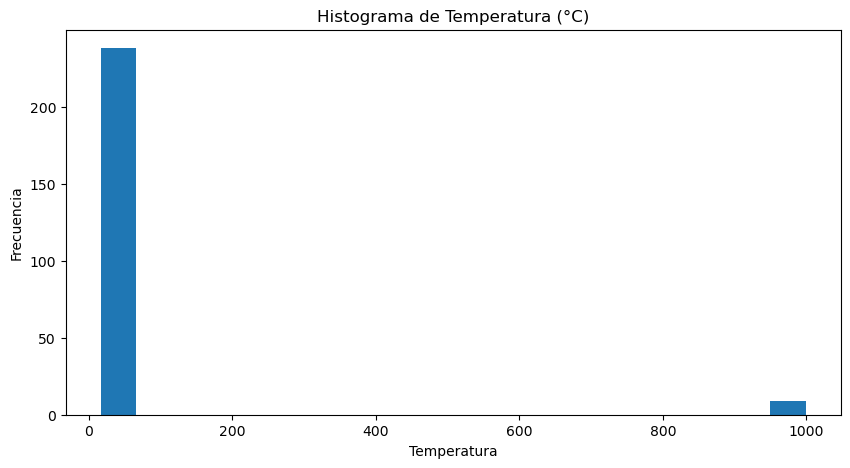

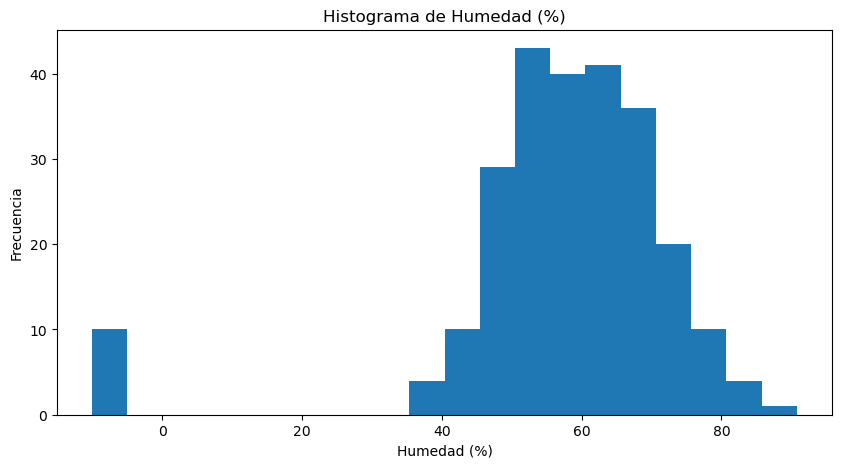

In [9]:
# HISTOGRAMAS
plt.figure(figsize=(10,5))
plt.hist(df['temperature_C'].dropna(), bins=20)
plt.title("Histograma de Temperatura (°C)")
plt.xlabel("Temperatura")
plt.ylabel("Frecuencia")
plt.show()

plt.figure(figsize=(10,5))
plt.hist(df['humidity_%'].dropna(), bins=20)
plt.title("Histograma de Humedad (%)")
plt.xlabel("Humedad (%)")
plt.ylabel("Frecuencia")
plt.show()

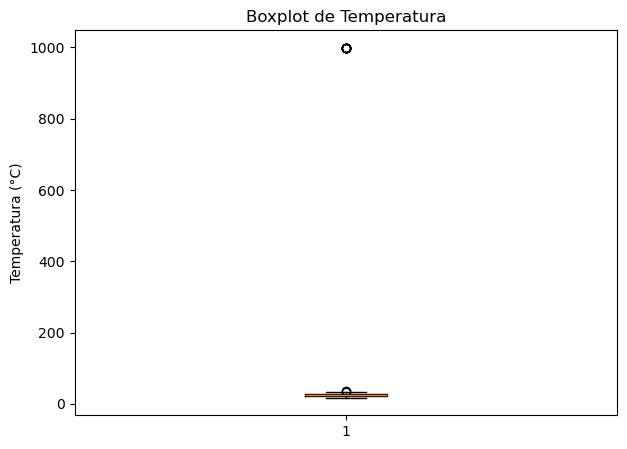

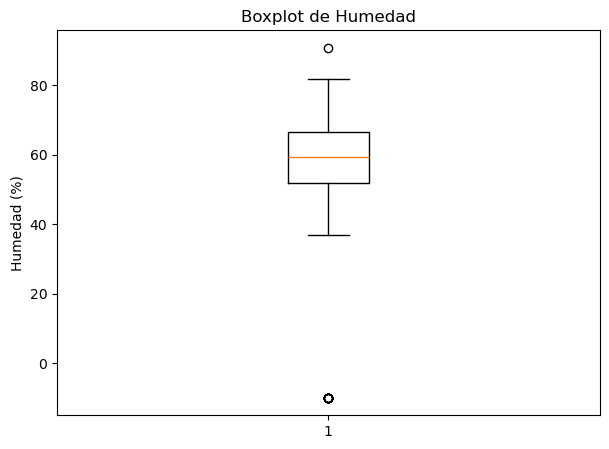

In [10]:
# BOXPLOTS
plt.figure(figsize=(7,5))
plt.boxplot(df['temperature_C'].dropna())
plt.title("Boxplot de Temperatura")
plt.ylabel("Temperatura (°C)")
plt.show()

plt.figure(figsize=(7,5))
plt.boxplot(df['humidity_%'].dropna())
plt.title("Boxplot de Humedad")
plt.ylabel("Humedad (%)")
plt.show()

In [11]:
# Conclusiones Técnicas
# 1. Se identificaron diversas anomalias, incluyendo fechas incorrectas, dispositivos sin identificación, valores imposibles y registros duplicados.
# 2. Estas anomalías indican fallos en sensores específicos.
# 3. La distribución de temperatura y humedad muestra que la mayoría de lecturas son normales, pero existen valores extremos que confirman fallos intermitentes.
# 4. Tras la limpieza, solo un subconjunto de datos puede considerarse confiable para análisis productivos.
# 5. El área de mantenimiento debe revisar sensores con fallos recurrentes, corregir la configuración horaria y validar la integridad de los dispositivos.
